In [4]:
import tensorflow as tf
import numpy as np, pandas as pd
import scipy.io
from sklearn.model_selection import train_test_split
import threading
import six, os, random, sys
# from keras.preprocessing import image
from datetime import datetime
import PIL
from tensorflow.python.keras._impl.keras.utils.generic_utils import CustomObjectScope
from tensorflow.python.keras._impl.keras.applications import xception


# image = keras.preprocessing.image

/home/lolik111/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
DATASET_FILE = 'cars_annos'
seed = 123
n_threads = 2
image_size=299
BATCH_SIZE=32

In [6]:
def read_mat(fname):
    mat = scipy.io.loadmat('../data/' + fname +'.mat')
    df = pd.DataFrame(mat['annotations'][0])
    labels = pd.DataFrame(mat['class_names'][0])
    labels = labels.applymap((lambda x: x[0]))
    df = df.applymap((lambda x: x[0]))
    df.loc[:, df.columns != 'relative_im_path'] = \
        df.loc[:, df.columns != 'relative_im_path'].applymap((lambda x: x[0]))
    return df, labels

dataset, label_map = read_mat(DATASET_FILE)

In [7]:
label_map

,0
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
5,Acura Integra Type R 2001
6,Acura ZDX Hatchback 2012
7,Aston Martin V8 Vantage Convertible 2012
8,Aston Martin V8 Vantage Coupe 2012
9,Aston Martin Virage Convertible 2012


In [ ]:
train = np.delete(dataset.values, 5, axis=1)
target = dataset.values[:, 5]
label_map = label_map.values.squeeze()

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(train, target, test_size=0.3, random_state=seed, stratify=target)

In [5]:
class ImageCoder(object):
    """Helper class that provides TensorFlow image coding utilities."""

    def __init__(self):
        self._sess = tf.Session()

        self._decode_jpeg_data = tf.placeholder(dtype=tf.string)
        self._decode_jpeg = tf.image.decode_jpeg(self._decode_jpeg_data, channels=3)
        self._to_raw = tf.image.encode_jpeg(self._decode_jpeg, format='rgb', quality=100)

    def decode_jpeg(self, image_data):
        image = self._sess.run(self._decode_jpeg,
                               feed_dict={self._decode_jpeg_data: image_data})
        assert len(image.shape) == 3
        assert image.shape[2] == 3
        return image
    
    def from_file_jpeg(self, filename):
        with tf.gfile.FastGFile(filename, 'rb') as f:
            image_data = f.read()
        image = self.decode_jpeg(image_data)
        height = image.shape[0]
        width = image.shape[1]
        return image_data, height, width
    
    def raws(self, filename):
        with tf.gfile.FastGFile(filename, 'rb') as f:
            image_data = f.read()
        image = self._sess.run(self._decode_jpeg,
                               feed_dict={self._decode_jpeg_data: image_data})
        assert len(image.shape) == 3
        height = image.shape[0]
        width = image.shape[1]
        if image.shape[2] == 3:
            return image_data, height, width
        else:
            image_data = self._sess.run(self._to_raw,
                               feed_dict={self._decode_jpeg_data: image_data})
            return image_data, height, width
        
    
    
def _int64_feature(value):
    """Wrapper for inserting int64 features into Example proto."""
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _float_feature(value):
    """Wrapper for inserting float features into Example proto."""
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def _bytes_feature(value):
    """Wrapper for inserting bytes features into Example proto."""
    if isinstance(value, six.string_types):
        value = six.binary_type(value, encoding='utf-8')
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [ ]:
def start_process(features, targets, label_map, num_shards=10, ds_type='train'):
    spacing = np.linspace(0, len(features), n_threads + 1, dtype=np.int)
    ranges = []
    threads = []
    for i in range(len(spacing) - 1):
        ranges.append([spacing[i], spacing[i + 1]])

        # Launch a thread for each batch.
    print('Launching %d threads for spacings: %s' % (n_threads, ranges))

        # Create a mechanism for monitoring when all threads are finished.
    coord = tf.train.Coordinator()

        # Create a generic TensorFlow-based utility for converting all image codings.
    coder = ImageCoder()

    threads = []
    for thread_index in range(len(ranges)):
        args = (coder, thread_index, ranges[thread_index], features, targets, num_shards, label_map, ds_type)
        t = threading.Thread(target=_process_image_files_batch, args=args)
        t.start()
        threads.append(t)

        # Wait for all the threads to terminate.
    coord.join(threads)
    print('%s: Finished writing all %d images in data set.' %
              (datetime.now(), len(features)))
    

def _process_image_files_batch(coder, thread_index, ranges, features, targets, num_shards, label_map, ds_type):
    
    assert not num_shards % n_threads
    num_shards_per_batch = int(num_shards / n_threads)

    shard_ranges = np.linspace(ranges[0],
                               ranges[1],
                               num_shards_per_batch + 1, dtype=np.int)
    num_files_in_thread = ranges[1] - ranges[0]

    counter = 0
    
    colorspace = 'RGB'
    channels = 3
    image_format = 'JPEG'
    
    for s in range(num_shards_per_batch):
        # Generate a sharded version of the file name, e.g. 'train-00002-of-00010'
        shard = thread_index * num_shards_per_batch + s
        output_filename = '%s-%.5d-of-%.5d' % (ds_type, shard, num_shards)
        output_file = os.path.join("tfrecords", output_filename)
        writer = tf.python_io.TFRecordWriter(output_file)

        shard_counter = 0
        files_in_shard = np.arange(shard_ranges[s], shard_ranges[s + 1], dtype=np.int)
        for i in files_in_shard:
            filename = '../data/' + features[i][0]
            label = targets[i]
            human = label_map[label - 1]

            image_buffer, height, width = coder.raws(filename)
            example = tf.train.Example(features=tf.train.Features(feature={
                'image/height': _int64_feature(height),
                'image/width': _int64_feature(width),
                'image/colorspace': _bytes_feature(colorspace),
                'image/channels': _int64_feature(channels),
                'image/class/label': _int64_feature(label),
                'image/class/text': _bytes_feature(human),
                'image/object/bbox/xmin': _float_feature(features[i][1]),
                'image/object/bbox/xmax': _float_feature(features[i][3]),
                'image/object/bbox/ymin': _float_feature(features[i][2]),
                'image/object/bbox/ymax': _float_feature(features[i][4]),
                'image/object/bbox/label': _int64_feature([label] * 1),
                'image/format': _bytes_feature(image_format),
                'image/filename': _bytes_feature(os.path.basename(filename)),
                'image/encoded': _bytes_feature(image_buffer)}))
            
            writer.write(example.SerializeToString())
            shard_counter += 1
            counter += 1

            if not counter % 100:
                print('%s [thread %d]: Processed %d of %d images in thread batch.' %
                      (datetime.now(), thread_index, counter, num_files_in_thread))
                sys.stdout.flush()

        writer.close()
        print('%s [thread %d]: Wrote %d images to %s' %
              (datetime.now(), thread_index, shard_counter, output_file))
        sys.stdout.flush()
        shard_counter = 0
    print('%s [thread %d]: Wrote %d images to %d shards.' %
          (datetime.now(), thread_index, counter, num_files_in_thread))


In [ ]:
start_process(X_tr, y_tr, label_map, num_shards=12, ds_type='train')
start_process(X_te, y_te, label_map, num_shards=6, ds_type='test')

In [ ]:
def parse_fn(example):
    "Parse TFExample records and perform simple data augmentation."
    example_fmt = {
        "image": tf.FixedLengthFeature((), tf.string, ""),
        "label": tf.FixedLengthFeature((), tf.int64, -1)
    }
    parsed = tf.parse_example(example, example_fmt)
    image = tf.image.decode_image(parsed["image"])
    image = _augment_helper(image)  # augments image using slice, reshape, resize_bilinear
    return image, parsed["label"]


def parse_example_proto(example_serialized):
    # Dense features in Example proto.
    feature_map = {
        'image/encoded': tf.FixedLenFeature([], dtype=tf.string,
                                            default_value=''),
        'image/class/label': tf.FixedLenFeature([1], dtype=tf.int64,
                                                default_value=-1),
        'image/class/text': tf.FixedLenFeature([], dtype=tf.string,
                                               default_value=''),
    }
    sparse_float32 = tf.VarLenFeature(dtype=tf.float32)
    # Sparse features in Example proto.
    feature_map.update(
        {k: sparse_float32 for k in ['image/object/bbox/xmin',
                                     'image/object/bbox/ymin',
                                     'image/object/bbox/xmax',
                                     'image/object/bbox/ymax']})

    
    
    features = tf.parse_single_example(example_serialized, feature_map)
    label = tf.cast(features['image/class/label'], dtype=tf.int32)
    
    ratio = tf.divide(tf.subtract(features['image/object/bbox/xmax'].values, features['image/object/bbox/xmin'].values),
                      tf.subtract(features['image/object/bbox/ymax'].values, features['image/object/bbox/ymin'].values))

    ratio = tf.reshape(ratio, [])

    ratio = tf.cond(ratio <= 1, lambda: ratio, lambda: tf.divide(1, ratio))
    
    height = tf.cast(features['image/height'], dtype=tf.float32)
    width = tf.cast(features['image/width'], dtype=tf.float32)

    xmin = tf.expand_dims(tf.divide(features['image/object/bbox/xmin'].values, width), 0)
    ymin = tf.expand_dims(tf.divide(features['image/object/bbox/ymin'].values, height), 0)
    xmax = tf.expand_dims(tf.divide(features['image/object/bbox/xmax'].values, width), 0)
    ymax = tf.expand_dims(tf.divide(features['image/object/bbox/ymax'].values, height), 0)
    

    # Note that we impose an ordering of (y, x) just to make life difficult.
    bbox = tf.concat(axis=0, values=[ymin, xmin, ymax, xmax])

    # Force the variable number of bounding boxes into the shape
    # [1, num_boxes, coords].
    bbox = tf.expand_dims(bbox, 0)
    bbox = tf.transpose(bbox, [0, 2, 1])

    return features['image/encoded'], label, bbox, features['image/class/text'], ratio

# def image_preprocessing(image_buffer, bbox, train):
#     if bbox is None:
#         raise ValueError('Please supply a bounding box.')

#     image = decode_jpeg(image_buffer)
    
# #     h_a, w_a = tf.shape(image)[0] / tf.shape(image)[1]
# #     if h_a > w_a:
# #         h_a, w_a = w_a, h_a 

#     if train:
# #         tf.image.sample_distorted_bounding_box(tf.shape(image), bounding_boxes=bbox, min_object_covered=0.7, 
# #                                                aspect_ratio_range=(h_a, w_a), )
# #         distorted_image, distorted_bbox = distorted_bounding_box_crop(image, bbox)
        
# #         image = distort_image(image, height, width, bbox, thread_id)
#         image = tf.image.crop_to_bounding_box
#     else:
#         image = eval_image(image, height, width)

#     return image


def input_fn():
    files = tf.data.Dataset.list_files("tfrecords/train-*.tfrecord")
    dataset = files.interleave(tf.data.TFRecordDataset, 1)
    dataset = tf.contrib.data.shuffle_and_repeat(1150)
    dataset = dataset.map(map_func=parse_example_proto, num_parallel_calls=n_threads)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=BATCH_SIZE)
    return dataset

In [29]:
file = '../data/car_ims/000001.jpg'
with tf.gfile.FastGFile(file, 'rb') as f:
    image_data = f.read()
coder = ImageCoder()
image = coder.decode_jpeg(image_data)
image_d, h, w = coder.from_file_jpeg(file)

(709, 1260, 3)

In [ ]:
# PIL.Image.fromarray(image)
c = tf.constant([[[7./768, 112./1024, 717./768, 853./1024]]], shape=(1, 1, 4), dtype=tf.float32)

op = tf.image.sample_distorted_bounding_box(tf.shape(image), bounding_boxes=c, min_object_covered=.8,
                                               aspect_ratio_range=(0.1, 10.), area_range=(0.05, 1.0), max_attempts=100)
bbox_begin, bbox_size, distort_bbox = op
fimage = tf.image.convert_image_dtype(image, dtype=tf.float32)
image_with_distorted_box = tf.image.draw_bounding_boxes(
                tf.expand_dims(fimage, 0), c)
image_with_distorted_box = tf.image.draw_bounding_boxes(
                    image_with_distorted_box, distort_bbox)
with tf.Session() as sess:
    bbox_begin, bbox_size, distort_bbox = sess.run(op)
    q = sess.run(image_with_distorted_box)
PIL.Image.fromarray(np.uint8(q.squeeze() * 255))

In [ ]:
tf.image.crop_to_bounding_box

In [ ]:
with CustomObjectScope({'relu6': mobilenet.relu6,'DepthwiseConv2D': mobilenet.DepthwiseConv2D}):
    model = tf.keras.applications.MobileNet()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    est = tf.keras.estimator.model_to_estimator(model, model_dir='out')

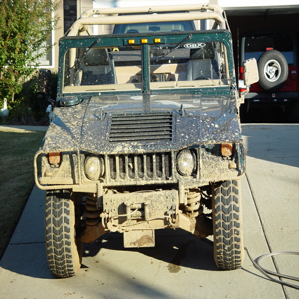

In [30]:
cartinka = PIL.Image.fromarray(image)
cartinka.resize((299, 299), resample=PIL.Image.BICUBIC)

array([[[201, 218, 234],
        [201, 218, 234],
        [201, 218, 234],
        ...,
        [236, 240, 241],
        [236, 240, 241],
        [236, 240, 241]],

       [[201, 218, 234],
        [201, 218, 234],
        [201, 218, 234],
        ...,
        [236, 240, 241],
        [236, 240, 241],
        [236, 240, 241]],

       [[201, 218, 234],
        [201, 218, 234],
        [201, 218, 234],
        ...,
        [236, 240, 241],
        [236, 240, 241],
        [236, 240, 241]],

       ...,

       [[154, 156, 106],
        [135, 135,  85],
        [166, 164, 115],
        ...,
        [ 87, 103,  56],
        [ 97, 113,  68],
        [ 87, 104,  59]],

       [[141, 143,  94],
        [127, 127,  77],
        [187, 185, 137],
        ...,
        [ 73,  91,  41],
        [100, 118,  70],
        [ 91, 109,  61]],

       [[135, 137,  90],
        [133, 132,  84],
        [188, 185, 140],
        ...,
        [ 68,  86,  36],
        [102, 120,  70],
        [ 79,  99,  48]]

In [35]:
distorted_image = tf.image.convert_image_dtype(image, dtype=tf.float32)

distorted_image = tf.image.resize_images(distorted_image, [image_size, image_size],
                                                 method=0)
distorted_image.set_shape([image_size, image_size, 3])
arr = tf.Session().run(distorted_image)

In [36]:
arr.shape

(299, 299, 3)

In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [32]:
np.argmax(model.predict(np.expand_dims(image, 0)))

659

In [37]:
np.argmax(model.predict(np.expand_dims(arr, 0)))

609